In [2]:
import sys, platform, os
print("Python:", sys.version.split()[0], "| Platform:", platform.platform(), "| CPUs:", os.cpu_count())

Python: 3.12.7 | Platform: macOS-15.6.1-arm64-arm-64bit | CPUs: 10


In [3]:
from pathlib import Path

# your dataset folder
DATA_DIR = Path("/Users/luqmanmuhammad/Desktop/MachineLearningCVE").resolve()

# Keep it tiny & fast:
FILES_MAX = 2                 # read at most 2 CSVs
NROWS_PER_FILE = 20000        # read only first 20k rows from each (adjust if you want)
SAMPLE_FRAC = 0.25            # after merge, keep only 25% to speed up everything
RANDOM_STATE = 42

ARTIFACTS_DIR = Path("artifacts_light").resolve()
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("Saving figures to:", ARTIFACTS_DIR)

DATA_DIR: /Users/luqmanmuhammad/Desktop/MachineLearningCVE
Saving figures to: /Users/luqmanmuhammad/Desktop/2 Scientific Writing/Final Code/artifacts_light


In [4]:
import warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)

In [5]:
def find_csvs(data_dir: Path):
    files = []
    for pat in ("*.csv","*.CSV"):
        files += sorted(data_dir.glob(pat))
    return files

files = find_csvs(DATA_DIR)[:FILES_MAX]
if not files:
    raise FileNotFoundError(f"No CSVs in {DATA_DIR}")

print("Reading (small slices):")
for f in files:
    print(" -", f.name)

dfs = []
for f in files:
    # read only first N rows -> super fast & memory-light
    df = pd.read_csv(f, nrows=NROWS_PER_FILE, low_memory=True)
    df.columns = [c.strip() for c in df.columns]
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)
print("Raw (sliced) shape:", raw.shape)
raw.head()

Reading (small slices):
 - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Raw (sliced) shape: (40000, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df = raw.copy()

# Ensure 'Label' exists
if "Label" not in df.columns:
    alt = [c for c in df.columns if c.lower() == "label"]
    if alt: df.rename(columns={alt[0]:"Label"}, inplace=True)
    else: raise KeyError("No 'Label' column found.")

# Drop obviously non-predictive IDs
drop_cols = [
    "Timestamp","Flow ID","Src IP","Dst IP","Source IP","Destination IP",
    "Src Port","Dst Port","Protocol","Fwd Header Length"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Convert to numeric where possible
for c in df.columns:
    if c == "Label": continue
    if df[c].dtype == object:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","").str.strip(), errors="coerce")

# Map label -> 0/1
df = df.dropna(subset=["Label"])
df["y"] = df["Label"].apply(lambda x: 0 if str(x).upper()=="BENIGN" else 1)
df = df.drop(columns=["Label"])

# Replace inf with NaN, cap outliers, drop NaNs
X = df.drop(columns=["y"])
y = df["y"].astype(int)

X = X.replace([np.inf, -np.inf], np.nan)
# cap to 1%..99.9% to avoid giant rates
lower = X.quantile(0.01, numeric_only=True)
upper = X.quantile(0.999, numeric_only=True)
X = X.clip(lower=lower, upper=upper, axis=1)
X = X.dropna()
y = y.loc[X.index]

# Optional: small random sample to keep runtime tiny
if SAMPLE_FRAC < 1.0:
    X, _, y, _ = train_test_split(X, y, train_size=SAMPLE_FRAC, stratify=y, random_state=RANDOM_STATE)

print("After cleaning & sampling:", X.shape, "positives:", int(y.sum()))

After cleaning & sampling: (9995, 77) positives: 281


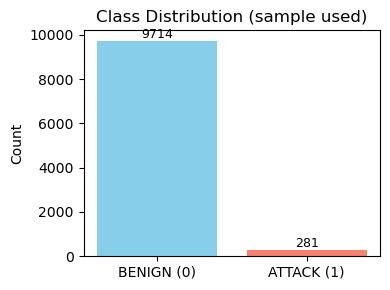

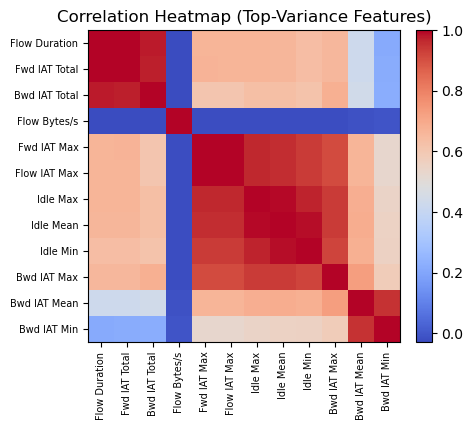

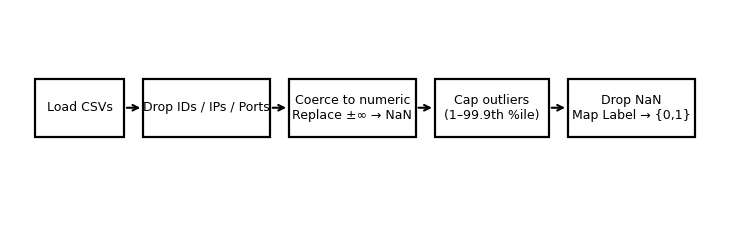

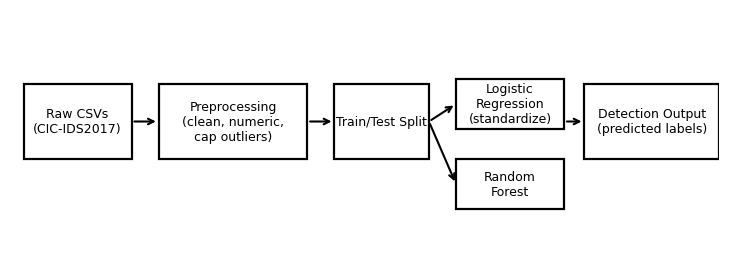

 Saved figures to: /Users/luqmanmuhammad/artifacts_light
 - Class_Distribution.png
 - Feature_Correlation_Top12.png
 - Preprocessing_Pipeline.png
 - Methods_Workflow.png


In [7]:
# ==== METHODS FIGURES (robust version — works with X/y OR with train/test splits) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Try to assemble X, y from what's available
if "X" in globals() and "y" in globals():
    X_used = X
    y_used = y
elif all(k in globals() for k in ["X_train","X_test","y_train","y_test"]):
    X_used = pd.concat([X_train, X_test], axis=0)
    y_used = pd.concat([y_train, y_test], axis=0)
else:
    raise RuntimeError("Neither (X,y) nor (X_train/X_test/y_train/y_test) are available.")

# ---- Normalize y_used into a clean 0/1 Series (fixes 'float has no attribute value_counts')
if isinstance(y_used, pd.DataFrame):
    if y_used.shape[1] == 1:
        y_used = y_used.iloc[:, 0]
    else:
        raise ValueError("y_used is a DataFrame with multiple columns; cannot infer label column.")
elif not isinstance(y_used, pd.Series):
    y_used = pd.Series(y_used)

# If labels are strings like 'BENIGN'/'ATTACK', map them to 0/1; otherwise coerce to numeric
y_map = y_used.astype(str).str.upper().map({"BENIGN": 0, "ATTACK": 1, "0": 0, "1": 1})
# Where mapping produced NaN, try numeric coercion from original values
y_coerced = pd.to_numeric(y_used, errors="coerce")
# Prefer mapped values when available, else numeric coercion
y_used = y_map.where(~y_map.isna(), y_coerced)
# Drop any remaining NaNs and cast to int
valid_idx = y_used.dropna().index
y_used = y_used.loc[valid_idx].astype(int)

# Align X with y and keep numeric-only copy for plotting correlations
if not isinstance(X_used, pd.DataFrame):
    X_used = pd.DataFrame(X_used)
X_used = X_used.loc[valid_idx]
X_num = X_used.select_dtypes(include=[np.number]).copy()

# Output folder
ARTIFACTS_DIR = Path("/Users/luqmanmuhammad/artifacts_light")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Class Distribution ----------
fig, ax = plt.subplots(figsize=(4,3))
counts = y_used.value_counts().sort_index()
ax.bar(["BENIGN (0)","ATTACK (1)"], [counts.get(0,0), counts.get(1,0)], color=["skyblue","salmon"])
ax.set_ylabel("Count"); ax.set_title("Class Distribution (sample used)")
for i,v in enumerate([counts.get(0,0), counts.get(1,0)]):
    ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
fig.tight_layout(); fig.savefig(ARTIFACTS_DIR/"Class_Distribution.png", dpi=220, bbox_inches="tight"); plt.show()

# ---------- 2) Feature Correlation (Top 12 by variance) ----------
if X_num.shape[1] >= 2:
    variances = X_num.var(numeric_only=True).sort_values(ascending=False)
    top_cols = variances.index[:12].tolist()
    corr = X_num[top_cols].corr()

    fig, ax = plt.subplots(figsize=(5.2,4.4))
    im = ax.imshow(corr.values, cmap="coolwarm", interpolation="nearest")
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(top_cols))); ax.set_yticks(range(len(top_cols)))
    ax.set_xticklabels(top_cols, rotation=90, fontsize=7)
    ax.set_yticklabels(top_cols, fontsize=7)
    ax.set_title("Correlation Heatmap (Top-Variance Features)")
    fig.tight_layout(); fig.savefig(ARTIFACTS_DIR/"Feature_Correlation_Top12.png", dpi=220, bbox_inches="tight"); plt.show()
else:
    print("Not enough numeric features for a correlation heatmap.")

# Helpers for diagrams
def _box(ax, xy, wh, text, lw=1.6, fs=9):
    x,y = xy; w,h = wh
    rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=lw)
    ax.add_patch(rect); ax.text(x+w/2, y+h/2, text, ha="center", va="center", fontsize=fs)

def _arrow(ax, start, end, lw=1.5):
    ax.annotate("", xy=end, xytext=start, arrowprops=dict(arrowstyle="->", lw=lw))

# ---------- 3) Preprocessing Pipeline ----------
fig, ax = plt.subplots(figsize=(7.4,2.6)); ax.axis("off")
steps = [
    ("Load CSVs", (0.04, 0.45), (0.14, 0.25)),
    ("Drop IDs / IPs / Ports", (0.21, 0.45), (0.20, 0.25)),
    ("Coerce to numeric\nReplace ±∞ → NaN", (0.44, 0.45), (0.20, 0.25)),
    ("Cap outliers\n(1–99.9th %ile)", (0.67, 0.45), (0.18, 0.25)),
    ("Drop NaN\nMap Label → {0,1}", (0.88, 0.45), (0.20, 0.25)),
]
for t,(x,y),(w,h) in steps: _box(ax, (x,y), (w,h), t)
for i in range(len(steps)-1):
    sx = steps[i][1][0] + steps[i][2][0]; sy = steps[i][1][1] + steps[i][2][1]/2
    ex = steps[i+1][1][0]; ey = steps[i+1][1][1] + steps[i+1][2][1]/2
    _arrow(ax, (sx,sy), (ex,ey))
ax.set_xlim(0,1.12); ax.set_ylim(0,1)
fig.tight_layout(); fig.savefig(ARTIFACTS_DIR/"Preprocessing_Pipeline.png", dpi=220, bbox_inches="tight"); plt.show()

# ---------- 4) Overall Workflow ----------
fig, ax = plt.subplots(figsize=(7.4,2.8)); ax.axis("off")
_box(ax, (0.02,0.40), (0.16,0.30), "Raw CSVs\n(CIC-IDS2017)")
_box(ax, (0.22,0.40), (0.22,0.30), "Preprocessing\n(clean, numeric,\ncap outliers)")
_box(ax, (0.48,0.40), (0.14,0.30), "Train/Test Split")
_box(ax, (0.66,0.52), (0.16,0.20), "Logistic\nRegression\n(standardize)")
_box(ax, (0.66,0.20), (0.16,0.20), "Random\nForest")
_box(ax, (0.85,0.40), (0.20,0.30), "Detection Output\n(predicted labels)")  # widened
_arrow(ax, (0.18,0.55), (0.22,0.55)); _arrow(ax, (0.44,0.55), (0.48,0.55))
_arrow(ax, (0.62,0.55), (0.66,0.62)); _arrow(ax, (0.62,0.55), (0.66,0.30)); _arrow(ax, (0.82,0.55), (0.85,0.55))
ax.set_xlim(0,1.05); ax.set_ylim(0,1)
fig.tight_layout(); fig.savefig(ARTIFACTS_DIR/"Methods_Workflow.png", dpi=220, bbox_inches="tight"); plt.show()

print(" Saved figures to:", ARTIFACTS_DIR)
print(" - Class_Distribution.png")
print(" - Feature_Correlation_Top12.png")
print(" - Preprocessing_Pipeline.png")
print(" - Methods_Workflow.png")

In [8]:
# Cell 6 / Cell 1 — SAFE train/test split (rebuild y if needed)

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# 1) Get a clean feature matrix
if "X" not in globals():
    raise RuntimeError("X is missing. Run your data-loading/cleaning cell first.")

X_num = (X.select_dtypes(include=[np.number])
           .replace([np.inf, -np.inf], np.nan)
           .dropna())
# 2) Reconstruct a proper label Series (y_series)
y_series = None

# Preferred: from your cleaned DataFrame
if "df" in globals() and isinstance(df, pd.DataFrame) and ("y" in df.columns):
    y_series = df.loc[X_num.index, "y"].astype(int)

# Fallback: if the global y is a proper Series of same length
elif "y" in globals() and isinstance(y, pd.Series) and len(y) == len(X):
    y_series = y.loc[X_num.index].astype(int)

# Fallback: if df still has Label (map again)
elif "df" in globals() and isinstance(df, pd.DataFrame) and ("Label" in df.columns):
    tmpy = df["Label"].apply(lambda x: 0 if str(x).upper()=="BENIGN" else 1)
    y_series = tmpy.loc[X_num.index].astype(int)

# Final fallback: try to find any column that looks like label
elif "df" in globals() and isinstance(df, pd.DataFrame):
    lab_candidates = [c for c in df.columns if c.lower() in {"label","y"}]
    if lab_candidates:
        col = lab_candidates[0]
        vals = df[col]
        if vals.dtype == object:
            vals = vals.apply(lambda x: 0 if str(x).upper()=="BENIGN" else 1)
        y_series = vals.loc[X_num.index].astype(int)

if y_series is None:
    raise RuntimeError("Could not rebuild labels. Make sure df['y'] exists (from your cleaning cell).")

# 3) Stratified split (lightweight)
X_train, X_test, y_train, y_test = train_test_split(
    X_num, y_series, test_size=0.25, stratify=y_series, random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Label ratio (train):", float(y_train.mean()), "| (test):", float(y_test.mean()))

Train: (7496, 77) | Test: (2499, 77)
Label ratio (train): 0.028148345784418355 | (test): 0.028011204481792718


In [9]:
# Cell 2 — Train Logistic Regression (scaled) + small Random Forest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# scale for LR
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)

# lightweight models
lr = LogisticRegression(max_iter=400, solver="saga", class_weight="balanced", n_jobs=1, penalty="l2", C=1.0)
lr.fit(Xtr, y_train)

rf = RandomForestClassifier(
    n_estimators=120, max_depth=12, n_jobs=1, random_state=42, class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)

print("Models trained: LR + RF")

Models trained: LR + RF


In [10]:
# Cell 3 — Helpers to display results inline (no files saved)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,3.2))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["BENIGN","ATTACK"]); ax.set_yticklabels(["BENIGN","ATTACK"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i,j], ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    fig.tight_layout()
    plt.show()

def show_roc_pr(y_true, y_score, prefix="Model"):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    fig, ax = plt.subplots(figsize=(4,3.2))
    ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    ax.plot([0,1],[0,1],'--')
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title(prefix+" ROC"); ax.legend()
    fig.tight_layout(); plt.show()

    # PR
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig, ax = plt.subplots(figsize=(4,3.2))
    ax.plot(r, p, label=f"AP={ap:.3f}")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title(prefix+" PR"); ax.legend()
    fig.tight_layout(); plt.show()

    return {"roc_auc": float(auc), "avg_precision": float(ap)}

def summarize(y_true, y_pred, y_score, name="Model"):
    print(f"=== {name} — Test Metrics ===")
    print(classification_report(y_true, y_pred, digits=4))
    show_confusion(y_true, y_pred, title=f"{name} Confusion Matrix")
    return show_roc_pr(y_true, y_score, prefix=name)

=== Logistic Regression — Test Metrics ===
              precision    recall  f1-score   support

           0     1.0000    0.9658    0.9826      2429
           1     0.4575    1.0000    0.6278        70

    accuracy                         0.9668      2499
   macro avg     0.7288    0.9829    0.8052      2499
weighted avg     0.9848    0.9668    0.9727      2499



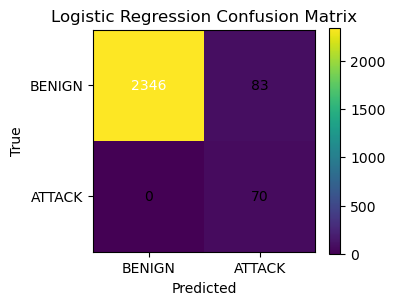

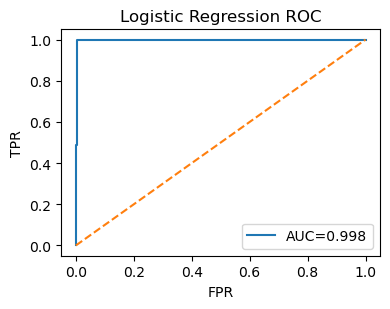

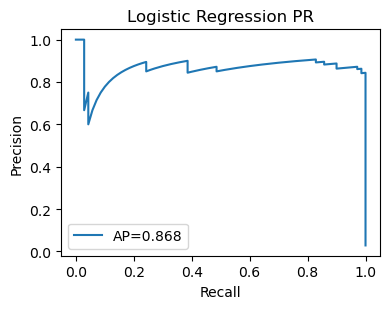

=== Random Forest — Test Metrics ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2429
           1     1.0000    1.0000    1.0000        70

    accuracy                         1.0000      2499
   macro avg     1.0000    1.0000    1.0000      2499
weighted avg     1.0000    1.0000    1.0000      2499



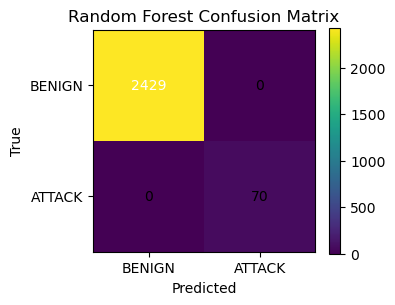

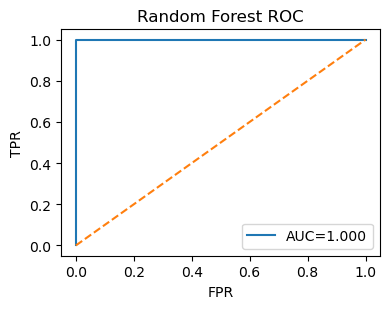

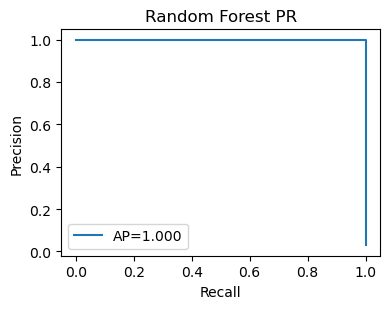

Score summary: {'LR': {'roc_auc': 0.9979415397282834, 'avg_precision': 0.8679489618198162}, 'RF': {'roc_auc': 1.0, 'avg_precision': 1.0}}


In [11]:
# Cell 4 — Evaluate both models with inline plots
# Logistic Regression
lr_prob = lr.predict_proba(Xte)[:,1]
lr_pred = (lr_prob >= 0.5).astype(int)
lr_scores = summarize(y_test, lr_pred, lr_prob, name="Logistic Regression")

# Random Forest
rf_prob = rf.predict_proba(X_test)[:,1]
rf_pred = (rf_prob >= 0.5).astype(int)
rf_scores = summarize(y_test, rf_pred, rf_prob, name="Random Forest")

print("Score summary:", {"LR": lr_scores, "RF": rf_scores})

In [12]:
# Cell 5 — Simple comparison
def model_rank(scores_dict):
    rows = []
    for m, s in scores_dict.items():
        rows.append((m, s["roc_auc"], s["avg_precision"]))
    rows = sorted(rows, key=lambda x: (x[1], x[2]), reverse=True)
    return rows

ranking = model_rank({"LR": lr_scores, "RF": rf_scores})
print("Model ranking (by ROC-AUC then AP):")
for i, (m, auc, ap) in enumerate(ranking, 1):
    print(f"{i}. {m} — ROC-AUC {auc:.3f}, AP {ap:.3f}")

best_name = ranking[0][0]
print("\nSelected best model:", best_name)

Model ranking (by ROC-AUC then AP):
1. RF — ROC-AUC 1.000, AP 1.000
2. LR — ROC-AUC 0.998, AP 0.868

Selected best model: RF


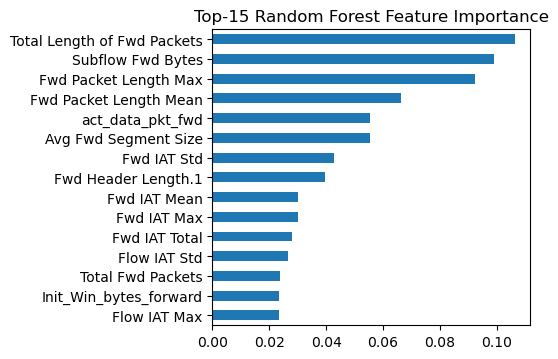

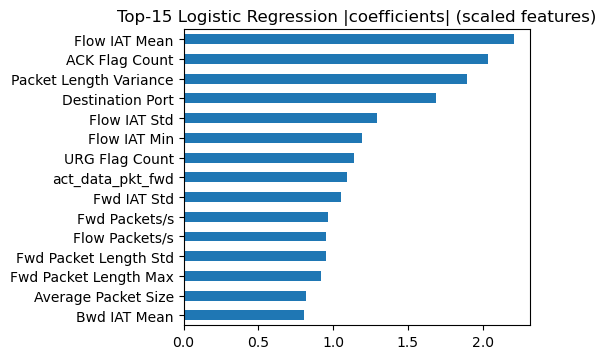

In [13]:
# Cell 6 — Interpretability: RF importance and LR coefficients (top 15)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random Forest importances
imp_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
imp_rf = imp_rf.sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(5.5,3.7))
imp_rf.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top-15 Random Forest Feature Importance")
fig.tight_layout(); plt.show()

# Logistic Regression absolute coefficients (note: after scaling)
coef_lr = pd.Series(lr.coef_.ravel(), index=X_train.columns)
coef_lr_abs = coef_lr.abs().sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(5.5,3.7))
coef_lr_abs.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top-15 Logistic Regression |coefficients| (scaled features)")
fig.tight_layout(); plt.show()

In [14]:
# Cell 7 — Show a few predictions (handy for report narrative)
ex = X_test.iloc[:8].copy()
df_pred = pd.DataFrame({
    "true_label": y_test.iloc[:8].values,
    "rf_proba_attack": rf.predict_proba(ex)[:,1],
    "lr_proba_attack": lr.predict_proba(scaler.transform(ex))[:,1]
}, index=ex.index)
df_pred["rf_pred"] = (df_pred["rf_proba_attack"] >= 0.5).astype(int)
df_pred["lr_pred"] = (df_pred["lr_proba_attack"] >= 0.5).astype(int)
df_pred.round(3)

,true_label,rf_proba_attack,lr_proba_attack,rf_pred,lr_pred
39302,0,0.0,0.587,0,1
39828,0,0.0,0.000,0,0
37430,0,0.0,0.003,0,0
20860,0,0.0,0.007,0,0
24600,0,0.0,0.000,0,0
28755,0,0.0,0.002,0,0
28342,0,0.0,0.004,0,0
22167,0,0.0,0.002,0,0


In [15]:
# Cell 8 — Compact “Results” snapshot (print-only, easy screenshot)
from sklearn.metrics import precision_score, recall_score, f1_score

def quick_scores(y_true, y_pred, name):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {"model": name, "precision": p, "recall": r, "f1": f1}

rows = []
rows.append(quick_scores(y_test, lr_pred, "Logistic Regression"))
rows.append(quick_scores(y_test, rf_pred, "Random Forest"))
pd.DataFrame(rows).set_index("model").round(3)

,precision,recall,f1
model,,,
Logistic Regression,0.458,1.0,0.628
Random Forest,1.000,1.0,1.000
